# Healthy or Not Healthy Classifier
This classifier is a simple sequential NN that predicts if someone is healthy or not depending on features derived from CDC survey data.


# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/ColabNotebooks/GoogleWorkshop/HealthModels/

/content/gdrive/MyDrive/ColabNotebooks/GoogleWorkshop/HealthModels


In [3]:
!mkdir models
!touch models/__init__.py

mkdir: cannot create directory ‘models’: File exists


#Import

In [9]:
from nodeanalysis.NodeAnalysis import NodeAnalysisCallback
from nodeanalysis.nodes.EmptyNode import EmptyNode
from nodeanalysis.nodes.SimpleNeuron import SimpleNeuron
from nodeanalysis.visualization.SimpleNeuronVis import showWeights, showBias
import tensorflow as tf 

# Build models
## Where did these models come from?
These models are from a previous research project and are just basic n-layer dense neural networks.

In [5]:
%%writefile models/simple_dense_models.py
import numpy as np
import tensorflow as tf
import random
import keras
from tensorflow.keras.callbacks import EarlyStopping

def build_1layer_model(input_shape=(1,2), hidden_layer=64, output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
  model_1layer = tf.keras.models.Sequential([
      tf.keras.layers.Dense(hidden_layer, input_shape=input_shape),
      tf.keras.layers.Dense(output_layer)
  ])

  model_1layer.compile(
      loss=loss,
      metrics=metrics
  )

  # model_1layer.summary()
  return model_1layer

def build_3layer_model(input_shape=(1,2), hidden_layer=[256,128,64], output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
  model_3layer = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer[0], input_shape=input_shape),
    tf.keras.layers.Dense(hidden_layer[1]),
    tf.keras.layers.Dense(hidden_layer[2]),
    tf.keras.layers.Dense(output_layer)
  ])
  model_3layer.compile(
      loss=loss,
      metrics=metrics #Acc not working, in testing
  )

  # model_3layer.summary()
  return model_3layer

def build_3layer_model_v2(input_shape=(1,2), hidden_layer=[256,128,64], output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
  model_3layer = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer[0], input_shape=input_shape),
    tf.keras.layers.Dense(hidden_layer[1], activation='relu'),
    tf.keras.layers.Dense(hidden_layer[2], activation='relu'),
    tf.keras.layers.Dense(output_layer, activation='softmax')
  ])
  model_3layer.compile(
      loss=loss,
      metrics=metrics #Acc not working, in testing
  )

  return model_3layer

def build_3layer_model_v3(input_shape=(1,2), hidden_layer=[256,128,64], output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
  model_3layer = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer[0], input_shape=input_shape),
    tf.keras.layers.Dense(hidden_layer[1], activation='sigmoid'),
    tf.keras.layers.Dense(hidden_layer[2], activation='sigmoid'),
    tf.keras.layers.Dense(output_layer, activation='softmax')
  ])
  model_3layer.compile(
      loss=loss,
      metrics=metrics #Acc not working, in testing
  )

  # model_3layer.summary()
  return model_3layer

def build_4layer_model(input_shape=(1,2), hidden_layer=[512,256,128,64], output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
  model_4layer = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer[0], input_shape=input_shape),
    tf.keras.layers.Dense(hidden_layer[1]),
    tf.keras.layers.Dense(hidden_layer[2]),
    tf.keras.layers.Dense(hidden_layer[3]),
    tf.keras.layers.Dense(output_layer)
  ])
  model_4layer.compile(
      loss=loss,
      metrics=metrics #Acc not working, in testing
  )

  # model_4layer.summary()
  return model_4layer

def build_5layer_model(input_shape=(1,2), hidden_layer=[1024,512,256,128,64], output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
  model_5layer = tf.keras.models.Sequential([
      tf.keras.layers.Dense(hidden_layer[0], input_shape=input_shape),
      tf.keras.layers.Dense(hidden_layer[1]),
      tf.keras.layers.Dense(hidden_layer[2]),
      tf.keras.layers.Dense(hidden_layer[3]),
      tf.keras.layers.Dense(hidden_layer[4]),
      tf.keras.layers.Dense(output_layer)
  ])
  model_5layer.compile(
      loss=loss,
      metrics=metrics #Acc not working, in testing
  )

  # model_5layer.summary()
  return model_5layer

Overwriting models/simple_dense_models.py


In [6]:
%%writefile models/simple_nondense_models.py


from tensorflow.keras.layers import Input, Lambda, Dense, concatenate
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

import os

def build_nondense_model(input_shape=(1,2), hidden_layer=[64], output_layer=1, loss="MeanSquaredError", metrics=["accuracy"]):
    model_name = "nondense_model"
    
    # Input layer of 3 neurons 
    inp = Input(shape=input_shape)
    
    #128 layer
    d2_out = Dense(hidden_layer[0])(inp)

    #grab first, 2nd half of the 128 layer
    d2_out_p1 = Lambda(lambda x: x[:,:,0:hidden_layer[0]])(d2_out)
    d2_out_p2 = Lambda(lambda x: x[:,:,hidden_layer[0]:hidden_layer[0]*2])(d2_out)

    #64 layer(s)
    d3_out = Dense(hidden_layer[0])(d2_out_p1)
    d4_out = Dense(hidden_layer[0])(d2_out_p2)

    #grab output nodes from both 64 layers
    d5_out = concatenate([d3_out, d4_out])
    
    o = Dense(output_layer)(d5_out)
    
    model = Model(inp, o)
    
    model._name = model_name
    
    model.compile(
        loss=loss,
        metrics=metrics
    )
    
    return model

Overwriting models/simple_nondense_models.py


# Data Visualization


In [7]:
%%writefile data/vis.py

from matplotlib import pyplot as plt

def print_acc_loss_graphs(history, model_name="model"):
  print(history.history.keys())
  #  "Accuracy"
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f"{model_name} accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f"{model_name} loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

Overwriting data/vis.py


# Testing


## Neural Networks 
Simple dense and nondense neural networks

Tensorboard Callback

In [10]:
logs_path = "tb25"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_path, histogram_freq=1)

Nodeanalysis Callback

In [11]:
nac = NodeAnalysisCallback()

### predictors

In [30]:
%%writefile test_julianna_models.py
import data.cdc as cdc
import data.cleaned as cln
import models.simple_dense_models as sdm
import models.simple_nondense_models as sdn
from nodeanalysis.NodeAnalysis import NodeAnalysisCallback
from nodeanalysis.nodes.EmptyNode import EmptyNode
from nodeanalysis.nodes.SimpleNeuron import SimpleNeuron
from nodeanalysis.visualization.SimpleNeuronVis import showWeights, showBias
import tensorflow as tf

#set up callbacks
logs_path = "tb25"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_path, histogram_freq=1)
nac = NodeAnalysisCallback()

# load data
cdc_data = cdc.download_brfss_data(year="2019")
columns = cdc.get_column_dictionary()

cdc_dataset1 = cdc.get_column_set(name="dhb", df=cdc_data)
target = columns["target"][0]

X_train, X_test, y_train, y_test = cln.remove_all_nulls(cdc_dataset1, target)

Overwriting test_julianna_models.py


In [31]:
%%writefile -a test_julianna_models.py

# train model
batch_size = 1000

model1 = sdm.build_4layer_model(input_shape=(1,cdc_dataset1.shape[1] - 1))
model2 = sdm.build_1layer_model(input_shape=(1,cdc_dataset1.shape[1] - 1))
model3 = sdm.build_3layer_model(input_shape=(1,cdc_dataset1.shape[1] - 1))
model4 = sdm.build_5layer_model(input_shape=(1,cdc_dataset1.shape[1] - 1))

# model5 = sdn.build_nondense_model(input_shape=(None, 1,cdc_dataset1.shape[1] - 1))

for model in [model1, model2, model3, model4]:
  history = model.fit(
      x = X_train,
      y = y_train,
      batch_size = batch_size,
      epochs = 10,
      validation_data = (X_test, y_test),
      # callbacks = None
      callbacks=[tensorboard_callback, nac]
  )

# GRAPH ACCURACY / LOSS / CONFUSION MATRIX (PUT THESE FUNCTIONS INTO FILE)

# FEATURE SELECTION ALGORITHMS (USE FEATURE SELECTION ALGORITHM) ADD THIS TO ITS OWN FILE

Appending to test_julianna_models.py


In [32]:
%%writefile -a test_julianna_models.py
from nodeanalysis.nodes.SimpleNeuron import SimpleNeuron
node = SimpleNeuron()
node.get(nac,-1,[1,1])
node.report()
h = node.history(node.epochs, SimpleNeuron)
from nodeanalysis.visualization import SimpleNeuronVis as V
layer = V.getNodesFromLayer(nac, -1, SimpleNeuron)
V.showWeights(h[0].history(h[0].epochs, SimpleNeuron))
V.showBias(h[0].history(h[0].epochs, SimpleNeuron))
#for node in layer:
#    V.showWeights(node.history(node.epochs, SimpleNeuron))
#    V.showBias(node.history(node.epochs, SimpleNeuron))   

Appending to test_julianna_models.py


In [33]:
!python test_julianna_models.py

2021-05-05 21:56:22.392529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-05 21:56:24.670906: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-05-05 21:56:24.670980: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-05-05 21:56:24.672500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-05 21:56:24.685763: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
tcmalloc: large alloc 1136852992 bytes == 0x564892c4c000 @  0x7f4a6291e1e7 0x56488ce3af48 0x56488ce059c7 0x56488cee73fe 0x56488ce08ee9 0x56488cefa99d 0x56488ce7cfe9 0x56488ce77e0d 0x56488ce0a77a 0x56488ce78c9e 0x56488ce77b0e 0x56488ce0a77a 0x56488ce7ce50 0x56488ce77b0e 0x56488ce0a77a 0x56488ce7986a 0x56488ce77b0e 0x56488ce77813 0x56488cf41592 0x56488cf4190d 0x56488cf417b6 0

#Weights: per my comment, why is the weight has only one value? shouldn't it be a vector?

### Classifiers

(321428, 1)
(64286, 7)
(257142, 7)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 128)         3840      
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          8256      
_________________________________________________________________
dense_2 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_3 (Dense)              (None, None, 7)           231       
Total params: 14,407
Trainable params: 14,407
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5143/5143 [==============================] - 11s 2ms/step - loss: 0.0888 - accuracy: 0.4789 - val_loss: 0.0764 - val_accuracy: 0.5581
Epoch 2/50
5143/5143 [==============================] - 9s 2ms/step - 

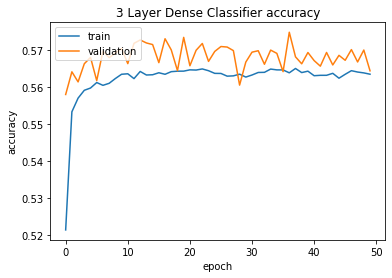

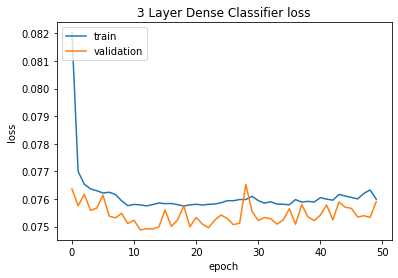

In [ ]:
# %%writefile test_julianna_classifiers.py
%matplotlib inline

import data.cdc as cdc
import data.cleaned as cln
import data.vis as vis
import models.simple_dense_models as sdm
import models.simple_nondense_models as sdn
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# load data
cdc_data = cdc.download_brfss_data(year="2019")
columns = cdc.get_column_dictionary()

cdc_dataset1 = cdc.get_column_set(name="dhb", df=cdc_data)
target = columns["target"][0]

X_train, X_test, y_train, y_test = cln.remove_all_nulls(cdc_dataset1, target, test_size=0.20)

enc = OneHotEncoder()
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(np.concatenate((y_train, y_test)).shape)

enc.fit(np.concatenate((y_train, y_test)))

y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()

print(y_test.shape)
print(y_train.shape)

# train model
batch_size = 50


# model3 = sdm.build_3layer_model(input_shape=(None, cdc_dataset1.shape[1] - 1), output_layer=y_train.shape[1], hidden_layer=[128, 64, 32])
# model3 = sdm.build_3layer_model_v2(input_shape=(None, cdc_dataset1.shape[1] - 1), output_layer=y_train.shape[1], hidden_layer=[128, 64, 32])
model3 = sdm.build_3layer_model_v3(input_shape=(None, cdc_dataset1.shape[1] - 1), output_layer=y_train.shape[1], hidden_layer=[128, 64, 32])

model = model3
model.summary()

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_data = (X_test, y_test),
    # callbacks = None
)

vis.print_acc_loss_graphs(history, model_name="3 Layer Dense Classifier")

# GRAPH ACCURACY / LOSS / CONFUSION MATRIX (PUT THESE FUNCTIONS INTO FILE)

# FEATURE SELECTION ALGORITHMS (USE FEATURE SELECTION ALGORITHM) ADD THIS TO ITS OWN FILE

## Random Forest Model
because we are using categorical data, I attempted to use a random forest

In [ ]:
%%writefile test_randomforest_model.py
# Import the model we are using
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import data.cdc as cdc
import data.cleaned as cln

# load data
cdc_data = cdc.download_brfss_data(year="2019")
columns = cdc.get_column_dictionary()

cdc_dataset1 = cdc.get_column_set(name="dhb", df=cdc_data)
target = columns["target"][0]

X_train, X_test, y_train, y_test = cln.remove_all_nulls(cdc_dataset1, target)

# Instantiate model with 50 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Overwriting test_randomforest_model.py


In [ ]:
!python test_randomforest_model.py

tcmalloc: large alloc 1136852992 bytes == 0x55a8fcae2000 @  0x7fa7b3b681e7 0x55a8f8e50f48 0x55a8f8e1b9c7 0x55a8f8efd3fe 0x55a8f8e1eee9 0x55a8f8f1099d 0x55a8f8e92fe9 0x55a8f8e8de0d 0x55a8f8e2077a 0x55a8f8e8ec9e 0x55a8f8e8db0e 0x55a8f8e2077a 0x55a8f8e92e50 0x55a8f8e8db0e 0x55a8f8e2077a 0x55a8f8e8f86a 0x55a8f8e8db0e 0x55a8f8e8d813 0x55a8f8f57592 0x55a8f8f5790d 0x55a8f8f577b6 0x55a8f8f2f103 0x55a8f8f2edac 0x7fa7b2952bf7 0x55a8f8f2ec8a
Mean Absolute Error: 0.51 degrees.
Accuracy: 77.22 %.


## Feature Selection

In [ ]:
# %%writefile feature_selection.py
%matplotlib inline
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import data.cdc as cdc
import data.cleaned as cln
import models.simple_dense_models as sdm
import models.simple_nondense_models as sdn

from sklearn.linear_model import LassoCV

def get_cols_from_support(support):
  result = []
  for x in range(len(support)):
    if support[x]:
       result.append(x)
    else:
      continue
  return result

# load data
print("data loading...")
cdc_data = cdc.download_brfss_data(year="2019")
columns = cdc.get_column_dictionary()

cdc_dataset1 = cdc.get_column_set(name="dhb", df=cdc_data)
target = columns["target"][0]

X_train, X_test, y_train, y_test = cln.remove_all_nulls(cdc_dataset1, target)

print("...COMPLETE")

# feature selection
print("feature selection starting...")
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import pandas as pd

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
print(featureScores)

#print 10 best features
# print(featureScores.nlargest(10,'Score').plot(kind='barh'))
print("...COMPLETE")

print(f"original shape: {X_train.shape} ")
print(f"selected shape: {X_selected.shape} ")

X_train = model.transform(X_train)
X_test = model.transform(X_test)

selected_columns = model.get_support()
selected_columns = get_cols_from_support(selected_columns)

print("SELECTED COLUMNS")
for column in selected_columns:
  print(cdc_dataset1.columns.values.tolist()[column])

import data.cdc as cdc
import data.cleaned as cln
import data.vis as vis
import models.simple_dense_models as sdm
import models.simple_nondense_models as sdn
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# load data
enc = OneHotEncoder()
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(np.concatenate((y_train, y_test)).shape)

enc.fit(np.concatenate((y_train, y_test)))

y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()

print(y_test.shape)
print(y_train.shape)

# train model
batch_size = 50


# model3 = sdm.build_3layer_model(input_shape=(None, cdc_dataset1.shape[1] - 1), output_layer=y_train.shape[1], hidden_layer=[128, 64, 32])
# model3 = sdm.build_3layer_model_v2(input_shape=(None, cdc_dataset1.shape[1] - 1), output_layer=y_train.shape[1], hidden_layer=[128, 64, 32])
model3 = sdm.build_3layer_model_v3(input_shape=(None, X_train.shape[1]), output_layer=y_train.shape[1], hidden_layer=[128, 64, 32])

model = model3
model.summary()

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_data = (X_test, y_test),
    # callbacks = None
)

vis.print_acc_loss_graphs(history, model_name="3 Layer Dense Classifier")

# GRAPH ACCURACY / LOSS / CONFUSION MATRIX (PUT THESE FUNCTIONS INTO FILE)

# FEATURE SELECTION ALGORITHMS (USE FEATURE SELECTION ALGORITHM) ADD THIS TO ITS OWN FILE

# # test model based on seleted
# rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

# # Train the model on training data
# rf.fit(X_train, y_train)

# # Use the forest's predict method on the test data
# predictions = rf.predict(X_test)

# # Calculate the absolute errors
# errors = abs(predictions - y_test)

# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y_test)

# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
!python feature_selection.py